# Hospital Readmissions Prediction

A significant healthcare challenge is the high rate of patient readmissions, with 20% within 30 days and 34% within 90 days, costing the industry $17.4 billion annually. This issue reflects underlying problems in hospital quality, post-care coordination, and misaligned financial incentives. In response, the Hospital Readmissions Reduction Program (HRRP) links Medicare reimbursements to hospitals' risk-adjusted readmission rates, penalizing those exceeding benchmarks for specific conditions. Tahoe, for instance, faced fines exceeding $750,000 in 2012, and potential losses could rise to $8,000 per readmitted patient if rates remain unaddressed. While pilot programs like CareTracker show promise, reducing readmissions by 40%, the $1,200 per patient cost prompts a cost-benefit analysis for system-wide implementation

This project was sourced from a Github repository to demonstrate the application of Machine Learning in different areas..

In [716]:
%matplotlib inline

from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import randint as sp_randint
from seaborn import pairplot

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

import mglearn

from sklearn.datasets import load_iris
import random
random.seed(15)
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import seaborn as sns

from collections import Counter

from imblearn.over_sampling import RandomOverSampler


In [717]:
# admissions over last year for patients with AMI

# severity score - generic physiologic severity of illness score based on lab tests and vital signs
# comorbidity score - severity score based on patients' pre-existing diagnoses
# readmit30 - indicator for hospital readmission within 30 day

df = pd.read_csv('Final Project Data_Case.csv').dropna()
df.tail()

age  female  flu_season  ed_admit  severity score  comorbidity score  \
4377   88       1           0         1              34                 94   
4378   98       0           0         1              51                136   
4379   84       1           0         1              10                 32   
4380   67       1           1         1              10                 73   
4381   79       1           0         1              20                 92   

      readmit30  
4377          0  
4378          0  
4379          0  
4380          0  
4381          0

In [718]:
# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)
df.tail()

age  female  flu_season  ed_admit  severity score  comorbidity score  \
4377   69       0           0         1              44                213   
4378   86       0           0         1              25                113   
4379   69       0           0         0              22                144   
4380   90       1           0         1              26                 54   
4381   77       1           1         1              26                 77   

      readmit30  
4377          0  
4378          0  
4379          0  
4380          0  
4381          0

>first train a classificiation model to predict whether a patient will readmit in 30 days
since there's class imbalance

>use SVM classifier, then rank feature importance



In [719]:
df['comorbidity score'].describe()

count    4382.000000
mean       94.735509
std        57.145155
min         1.000000
25%        51.000000
50%        86.000000
75%       131.000000
max       322.000000
Name: comorbidity score, dtype: float64

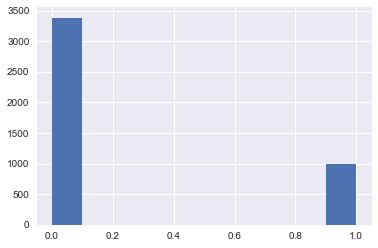

In [347]:
df['readmit30'].hist();

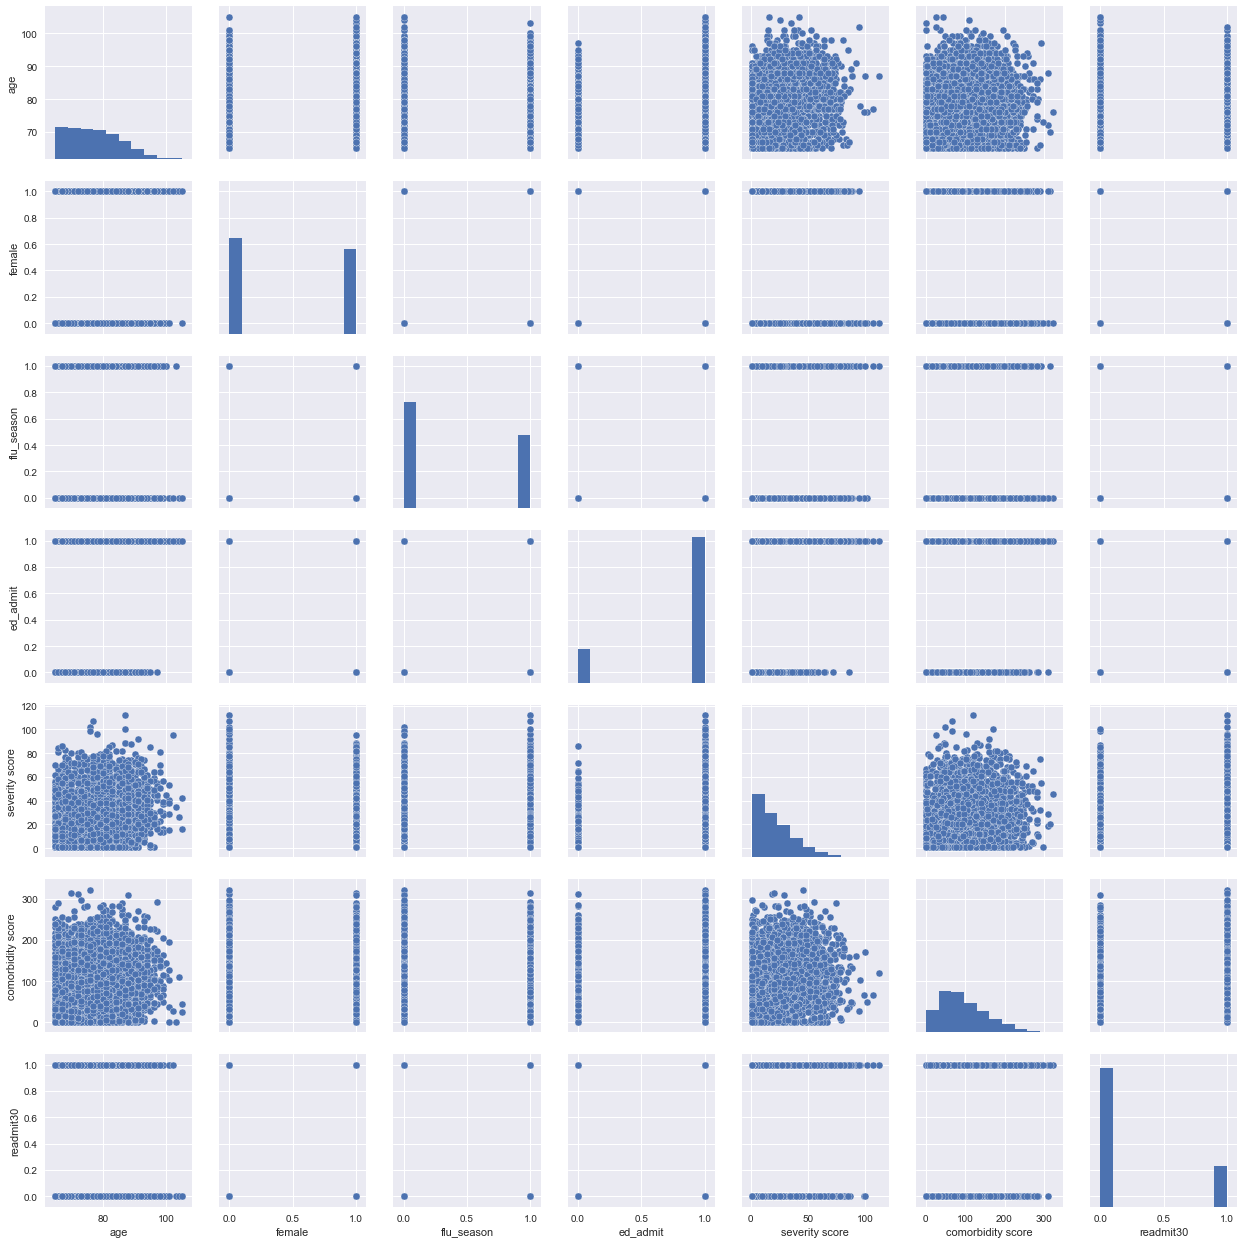

In [13]:
# check for relationships
pairplot(df);

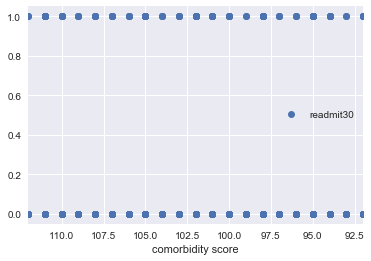

In [126]:
df.plot(x='comorbidity score', y='readmit30', style='o');

In [720]:
# there's class imbalance, and readmits are the minority class
print(Counter(df['readmit30']))

readmits = df[df['readmit30'] == 1]
readmits.tail()

Counter({0: 3384, 1: 998})


age  female  flu_season  ed_admit  severity score  comorbidity score  \
4365   86       0           1         1              33                 77   
4366   83       0           0         1              19                 98   
4367   66       0           0         1              24                180   
4368   69       1           1         0              35                 53   
4376   99       1           1         1              28                140   

      readmit30  
4365          1  
4366          1  
4367          1  
4368          1  
4376          1

In [349]:
X_holdout = df.ix[:599,:6]

y_holdout = df['readmit30'][:600]
df = df.ix[599:,:]

In [350]:
df.shape

(3783, 7)

In [351]:
y_holdout.shape

(600,)

In [352]:
X_holdout.shape

(600, 6)

In [721]:
X = df.ix[:,:6]
y = df['readmit30']

# up-sample: resample the minority class to deal with class imbalance

# !pip install -U imbalanced-learn
# from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_sample(X, y)

print(X_resampled.shape)

# default 75-25 train test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, random_state=0)

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

(6768, 6)
X_train shape: (5076, 6)
y_train shape: (5076,)
X_test shape: (1692, 6)
y_test shape: (1692,)


In [354]:
X_train[:,4:6]

array([[ 27,  98],
       [ 14, 110],
       [ 25, 222],
       ..., 
       [ 14,  64],
       [ 12,  67],
       [ 46, 149]])

In [355]:
X_train

array([[ 81,   0,   0,   0,  27,  98],
       [ 76,   0,   0,   1,  14, 110],
       [ 72,   1,   0,   1,  25, 222],
       ..., 
       [ 77,   1,   1,   1,  14,  64],
       [ 70,   0,   0,   1,  12,  67],
       [ 75,   0,   1,   1,  46, 149]])

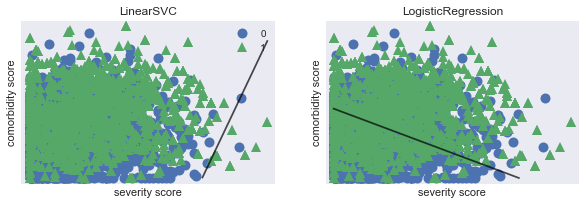

In [722]:
# train classifiers using severity score comorbidity score

# X = np.array(X_train[['severity score', 'comorbidity score']])
X = np.array(X_train[:,4:6])
y = np.array(y_train)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
for model, ax in zip([LinearSVC(), LogisticRegression()], axes):
    clf = model.fit(X, y)
    
    # visualize decision boundary found by linear model
    mglearn.plots.plot_2d_separator(clf, X, fill=False, eps=0.5,
    ax=ax, alpha=.7)
    mglearn.discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_title("{}".format(clf.__class__.__name__))
    ax.set_xlabel("severity score")
    ax.set_ylabel("comorbidity score")
axes[0].legend()

# Decision boundaries of a linear SVM and logistic regression on the dataset with the default parameters

linear methods won't work, use nonlinear methods

In [357]:
def decision_boundary(clf, X, Y, h=.02):
    """Inputs:
        clf - a trained classifier, with a predict method
    """
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(12, 9))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.show()

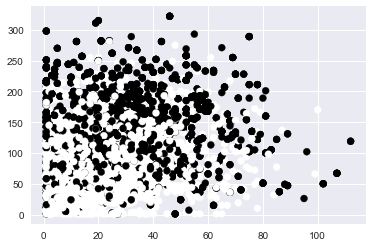

In [358]:
# X = X_train.as_matrix()
# y = y_train.as_matrix()

# severity and comorbidity
plt.scatter(X[:,0],X[:,1],c = y)

In [359]:
# make a mini set for illustration purposes
len(X[::25])

177

In [360]:
len(y[::25])

177

In [33]:
clf = SVC(kernel='poly')

clf.fit(X[::25], y[::25])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

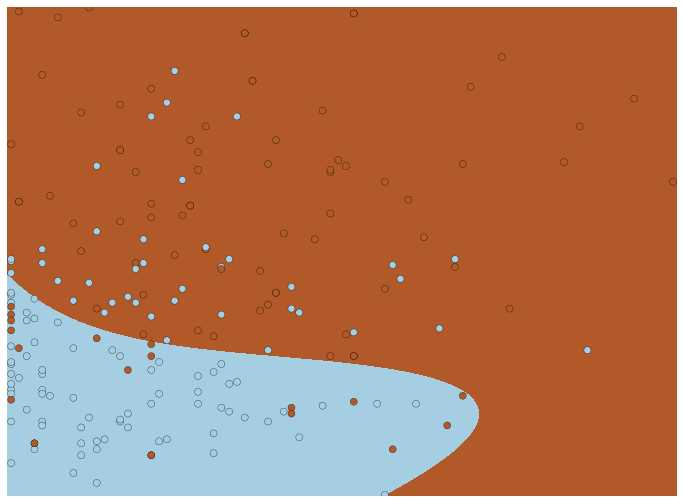

In [34]:
decision_boundary(clf, X[::25], y[::25])

In [35]:
print("Done")

Done


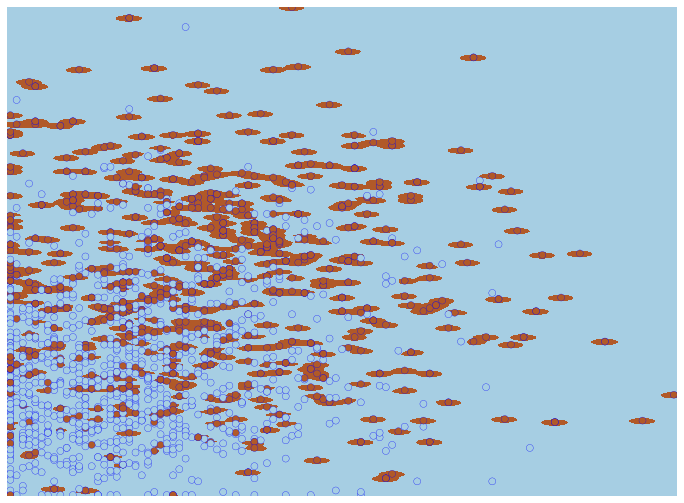

In [55]:
decision_boundary(clf, X[::3], y[::3])

In [56]:
print("Done")

Done


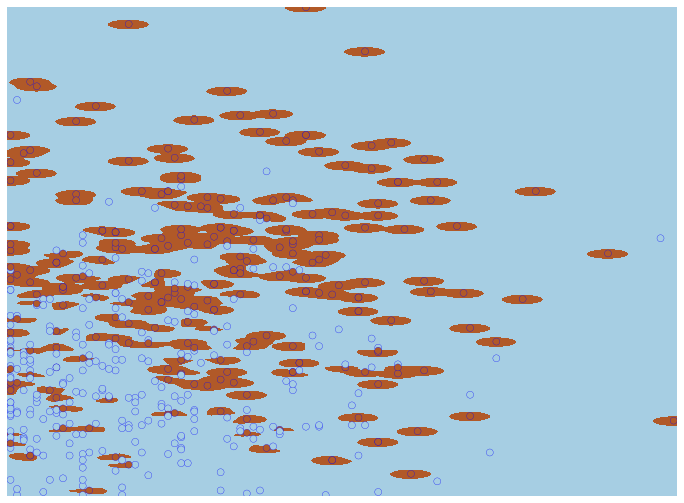

In [30]:
decision_boundary(clf, X[::10], y[::10])

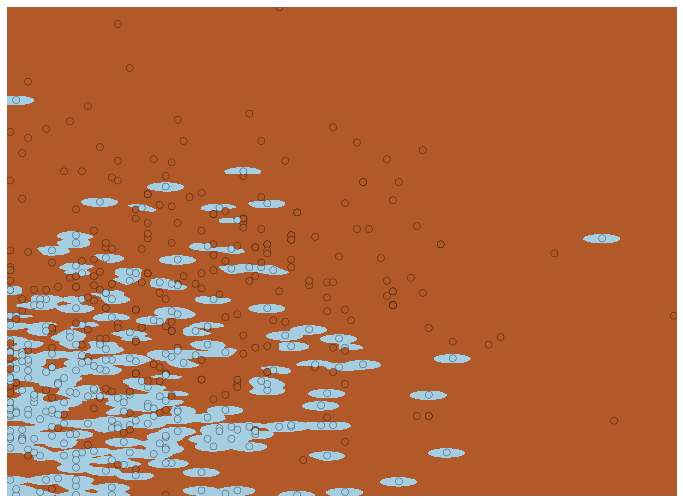

In [60]:
decision_boundary(clf, X[::10], y[::10])

In [361]:
# grid search for parameters C and gamma

# C = 1
# gamma = [1e-1, 1, 1e1]
# classifiers = []
# for gamma in gamma:
#     clf = SVC(C=1, gamma=gamma)
#     clf.fit(X, y)
#     decision_boundary(clf,X,y)
    
# C = [1E-1,1,10,100]
# gamma = 250
# classifiers = []
# for C in C:
#     clf = SVC(C=C, gamma=gamma)
#     clf.fit(X, y)
#     decision_boundary(clf,X,y)

In [362]:
# default kernel is kernel='rbf', other nonlinear kernels are poly and sigmoid

# clf = SVC(kernel = 'poly')
# clf.fit(X, y)
# decision_boundary(clf,X,y)

# clf = SVC(kernel = 'sigmoid')
# clf.fit(X_small, y_small)
# decision_boundary(clf,X_small,y_small)

In [723]:
# now use all the features

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Returns the mean accuracy on the given test data and labels.

print("Training set score: {:.2f}".format(clf.score(X_train, y_train)))
print("Test set score: {:.2f}".format(clf.score(X_test, y_test)))

Training set score: 0.71
Test set score: 0.71


In [724]:
# now use all the features

# clf = SVC() # use default values for C and gamma
# clf.fit(X_train, y_train)

y_pred = clf.predict(X_holdout)

# Returns the mean accuracy on the given test data and labels.

print("Training set score: {:.2f}".format(clf.score(X_train, y_train)))
print("Test set score: {:.2f}".format(clf.score(X_holdout, y_holdout)))

Training set score: 0.71
Test set score: 0.74


In [725]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Training set score: {:.2f}".format(clf.score(X_train, y_train)))
print("Test set score: {:.2f}".format(clf.score(X_test, y_test)))

Training set score: 0.71
Test set score: 0.70


In [728]:
from sklearn.ensemble import RandomForestClassifier

# now use all the features

clf = RandomForestClassifier() # use default values for C and gamma
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Returns the mean accuracy on the given test data and labels.

print("Training set score: {:.2f}".format(clf.score(X_train, y_train)))
print("Test set score: {:.2f}".format(clf.score(X_holdout, y_holdout)))

Training set score: 0.99
Test set score: 0.96


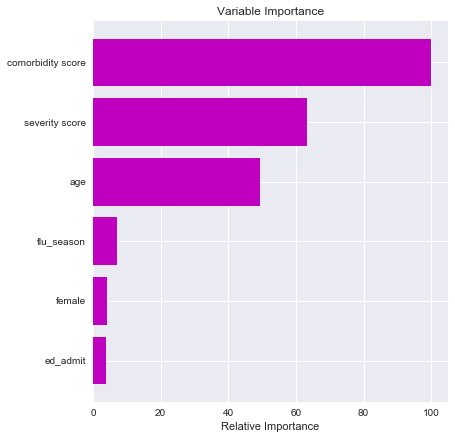

In [367]:
# Plot feature importance

feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

fig = plt.figure(figsize=(14,7))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center', color='m')

plt.yticks(pos, np.array(list(df))[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [729]:
# now use all the features

clf = SVC() # use default values for C and gamma
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Returns the mean accuracy on the given test data and labels.

print("Training set score: {:.2f}".format(clf.score(X_train, y_train)))
print("Test set score: {:.2f}".format(clf.score(X_test, y_test)))

Training set score: 0.99
Test set score: 0.90


In [730]:
# now use all the features

# clf = SVC() # use default values for C and gamma
# clf.fit(X_train, y_train)

y_pred = clf.predict(X_holdout)

# Returns the mean accuracy on the given test data and labels.

print("Training set score: {:.2f}".format(clf.score(X_train, y_train)))
print("Test set score: {:.2f}".format(clf.score(X_holdout, y_holdout)))

Training set score: 0.99
Test set score: 0.95


In [731]:
clf = SVC(random_state=0)

# specify parameters and distributions to sample from
# set the parameters by cross-validation
# C = [1E-1,1,10,100]
# gamma = [1e-1, 1, 1e1]

# default C is 1 and default gamma is 1/n_features = 1/6
param_dist = {"C": sp_randint(1, 100),
              "gamma": [.1, 'auto', 1],
             }
            
# run randomized search
# n_iter_search = 20
n_iter_search = 10
random_search = RandomizedSearchCV(clf,
                    param_distributions=param_dist,
                    cv=5,
                    n_iter=n_iter_search,
#                     n_jobs=-1
                   )
# 5-fold cross validation

In [732]:
start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

RandomizedSearchCV took 45.07 seconds for 10 candidates parameter settings.


In [733]:
# random_search.cv_results_

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            

# report(random_search.cv_results_)


report(random_search.cv_results_, n_top=1)

Model with rank: 1
Mean validation score: 0.933 (std: 0.009)
Parameters: {'gamma': 1, 'C': 32}

Model with rank: 1
Mean validation score: 0.933 (std: 0.009)
Parameters: {'gamma': 1, 'C': 91}

Model with rank: 1
Mean validation score: 0.933 (std: 0.009)
Parameters: {'gamma': 1, 'C': 45}



In [737]:
# now use all the features

clf = SVC(C=15, gamma=1) # use default values for C and gamma
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Returns the mean accuracy on the given test data and labels.

print("Training set score: {:.4f}".format(clf.score(X_train, y_train)))
print("Test set score: {:.2f}".format(clf.score(X_holdout, y_holdout)))

Training set score: 0.9994
Test set score: 0.99


In [374]:
# personalized intervention, identify subgroups that would benefit from CareTracker, let sleeping dogs lie
# let's construct an uplift model to directly model the incremental impact of intervention
# maximizes return on investment by targeting the persuadables

first, calculate the costs if without any CareTracker intervention

assumptions:

$8k loss in Medicare reimbursements per readmitted patient (2014), based off CFO Leila Houssein's estimated figure

so with our given dataset, we have 998 readmits, 998*8000 = 7,984,000

In [375]:
df = pd.read_csv('Final Project Data_Case.csv').dropna()
readmits = df[df['readmit30'] == 1]
len(readmits)

998

now suppose we introduce CareTracker to all 4382 patients

our cost would be 4382*1200 = 5,258,400 for CareTracker, but we'd expect to recoup $ through preventing readmission.

CareTracker has shown to reduce readmission by % in the past, that means instead of 998 we'd expect x readmits, reducing penalties by $xx.  So the net loss is x.

In [706]:
4382*1200 + (8000*.6*998)

10048800.0

In [376]:
len(df)

4382

In [377]:
4382*1200

5258400

In [378]:
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

cm_train = confusion_matrix(y_train,
                            clf.predict(X_train))
cm_train

array([[2196,    3],
       [   0, 2212]])

In [379]:
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

cm_train = confusion_matrix(y_test,
                            clf.predict(X_test))
cm_train

array([[741,   1],
       [ 68, 661]])

In [380]:
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

cm_holdout = confusion_matrix(y_holdout,
                            clf.predict(X_holdout))
cm_holdout

array([[443,   1],
       [155,   1]])

In [381]:
# Thus in binary classification, the count of true negatives is
# :math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
# :math:`C_{1,1}` and false positives is :math:`C_{0,1}`.

# true negatives is quadrant II, true positibes is quadrant I
m = cm_holdout
print('true negatives: ', m[0][0])
print('false negatives: ', m[1][0])
print('true positives: ', m[1][1])
print('false positives: ', m[0][1])

true negatives:  443
false negatives:  155
true positives:  1
false positives:  1


In [382]:
import matplotlib.pyplot as plt
import numpy as np

def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    Source: http://notmatthancock.github.io/2015/10/28/confusion-matrix.html
    """
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)
    
    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))
    
    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))
    
    plt.tight_layout()
    plt.show()
    
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    Source: http://notmatthancock.github.io/2015/10/28/confusion-matrix.html
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)

    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))
    
    plt.tight_layout()
    plt.show()

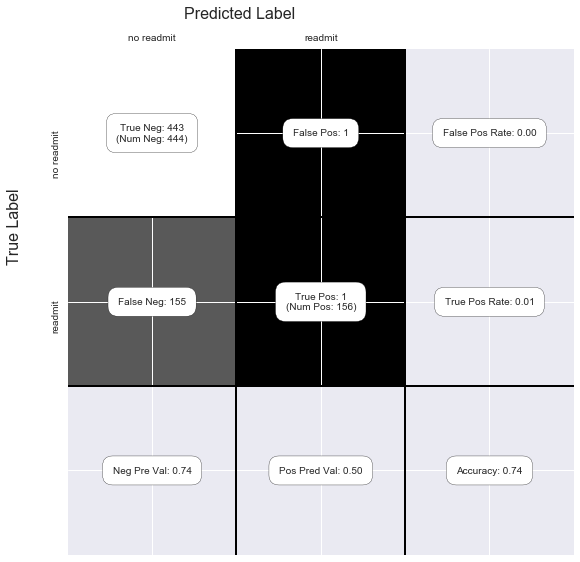

In [383]:
show_confusion_matrix(cm_holdout,
                     class_labels=["no readmit", "readmit"])

In [384]:
cm_holdout

array([[443,   1],
       [155,   1]])

In [385]:
sum(cm_holdout)

array([598,   2])

In [388]:
1/600

0.0016666666666666668

In [389]:
155/600

0.25833333333333336

In [387]:
157+42+1+1

201

In [594]:
1200*.4 + 9200*.6

6000.0

In [708]:
1200+.6*8000

6000.0

In [625]:
cost = np.array([[0, 1200], [8000, 6000]])
cost

array([[   0, 1200],
       [8000, 6000]])

In [626]:
cm_percentages = cm_holdout/600
cm_percentages

array([[ 0.73833333,  0.00166667],
       [ 0.25833333,  0.00166667]])

In [627]:
ppl = cm_percentages*4382

In [773]:
ppl

array([[ 3235.37666667,     7.30333333],
       [ 1132.01666667,     7.30333333]])

In [774]:
ppl*cost

array([[  0.00000000e+00,   8.76400000e+03],
       [  9.05613333e+06,   4.38200000e+04]])

In [775]:
sum(sum(ppl*cost))

9108717.3333333358

In [776]:
no_care_tracker = 998*8000

In [777]:
quadratic_discriminant_analysis = 6037465.6934306575

In [802]:
4382 * 1200 + 600*8000

10058400

In [940]:
# admissions over last year for patients with AMI
# severity score - generic physiologic severity of illness score based on lab tests and vital signs
# comorbidity score - severity score based on patients' pre-existing diagnoses
# readmit30 - indicator for hospital readmission within 30 day

df = pd.read_csv('Final Project Data_Case.csv').dropna()
df.tail()

age  female  flu_season  ed_admit  severity score  comorbidity score  \
4377   88       1           0         1              34                 94   
4378   98       0           0         1              51                136   
4379   84       1           0         1              10                 32   
4380   67       1           1         1              10                 73   
4381   79       1           0         1              20                 92   

      readmit30  
4377          0  
4378          0  
4379          0  
4380          0  
4381          0

In [941]:
Counter(df['readmit30'])

Counter({0: 3384, 1: 998})

In [942]:
X = df.ix[:,:6]
y = df['readmit30']

# default 75-25 train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=171)

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (3286, 6)
y_train shape: (3286,)
X_test shape: (1096, 6)
y_test shape: (1096,)


In [943]:
# Quadratic Discriminant Analysis
# A classifier with a quadratic decision boundary, generated by fitting class conditional densities 
# to the data and using Bayes’ rule.
# The model fits a Gaussian density to each class.

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Training set score: {:.3f}".format(clf.score(X_train, y_train)))
print("Test set score: {:.2f}".format(clf.score(X_test, y_test)))

Training set score: 0.787
Test set score: 0.83


In [944]:
cm_train = confusion_matrix(y_test,
                            clf.predict(X_test))
cm_train

array([[816,  52],
       [136,  92]])

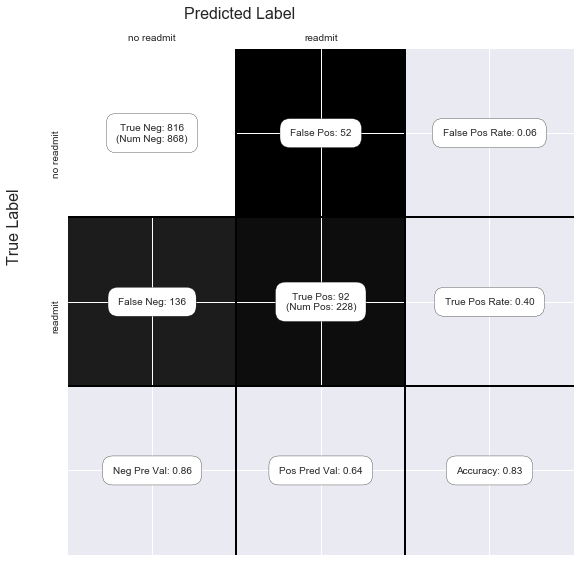

In [945]:
show_confusion_matrix(cm_train,
                     class_labels=["no readmit", "readmit"])

In [946]:
train_population = sum(sum(cm_train))
cm_percentages = cm_train/train_population
all_patients = cm_percentages * 4381
total_cost_with_model = sum(sum(all_patients * cost))
total_cost_with_model

6804940.1459854022

In [947]:
all_patients

array([[ 3261.76642336,   207.85766423],
       [  543.62773723,   367.74817518]])

In [948]:
# no care tracker at all
8000*998

7984000

In [949]:
# savings
savings = 7984000 - total_cost_with_model
savings

# depending on the random state of the train-test split, we could have 80k or 1.17M

1179059.8540145978

In [883]:
# 4382-998

# perfect = np.array([[ 3384,  0],
#        [ 0,  998]])

# cost
# .6*998
# 998*1200 + 598.8*8000

In [908]:
def try_different_random_states():
    X = df.ix[:,:6]
    y = df['readmit30']

    # default 75-25 train test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y)

#     print("X_train shape: {}".format(X_train.shape))
#     print("y_train shape: {}".format(y_train.shape))
#     print("X_test shape: {}".format(X_test.shape))
#     print("y_test shape: {}".format(y_test.shape))

    # Quadratic Discriminant Analysis
    # A classifier with a quadratic decision boundary, generated by fitting class conditional densities 
    # to the data and using Bayes’ rule.
    # The model fits a Gaussian density to each class.

    from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

    clf = QuadraticDiscriminantAnalysis()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
#     print("Training set score: {:.3f}".format(clf.score(X_train, y_train)))
#     print("Test set score: {:.2f}".format(clf.score(X_test, y_test)))

    cm_train = confusion_matrix(y_test,
                                clf.predict(X_test))

    train_population = sum(sum(cm_train))
    cm_percentages = cm_train/train_population
    all_patients = cm_percentages * 4381
    total_cost_with_model = sum(sum(all_patients * cost))
    total_cost_with_model

    # savings
    savings = 7984000 - total_cost_with_model
    return savings

# depending on the random state of the train-test split, we could have 80k or 1.17M

v=[]
for i in range(10000):
    v.append(try_different_random_states())
    
# print(v)

In [909]:
import pprint
pprint.pprint(pd.core.series.Series(v).describe())

count    1.000000e+04
mean     4.094681e+05
std      3.531484e+05
min     -1.037023e+06
25%      1.701507e+05
50%      4.179810e+05
75%      6.418277e+05
max      1.829814e+06
dtype: float64


In [910]:
possible_savings = pd.core.series.Series(v).describe()

In [911]:
min(pd.core.series.Series(v).describe())

-1037022.627737226

In [912]:
max(pd.core.series.Series(v).describe())

1829814.2335766423

In [913]:
np.mean(pd.core.series.Series(v).describe())

349420.95641262305

In [914]:
np.std(pd.core.series.Series(v).describe())

737814.0206160117

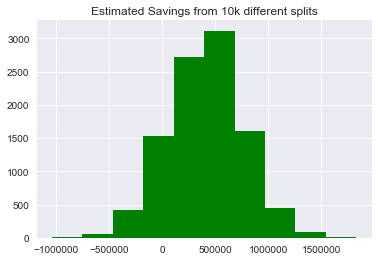

In [921]:
plt.hist(pd.core.series.Series(v), color = 'g')
plt.title('Estimated Savings from 10k different splits')

ROC AUC: 0.78


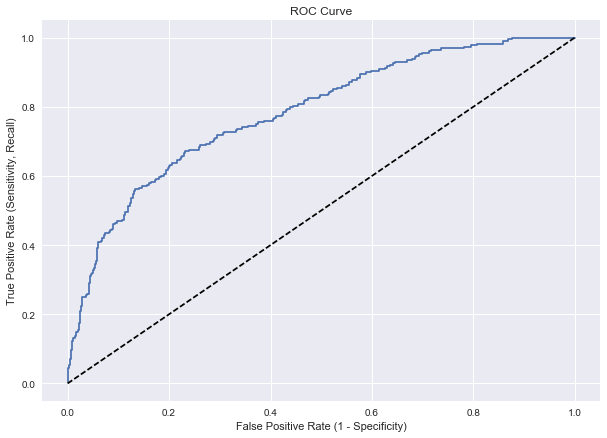

In [950]:
from sklearn.metrics import roc_curve, auc

probabilities = clf.predict_proba(X_test)[:, 1]

fpr,tpr,threshold = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)
print ("ROC AUC: %0.2f" % roc_auc)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")


plt.show()

In [5]:
print("Test set score: {:.2f}".format(.80))

Test set score: 0.80
